In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import signal

%matplotlib widget

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

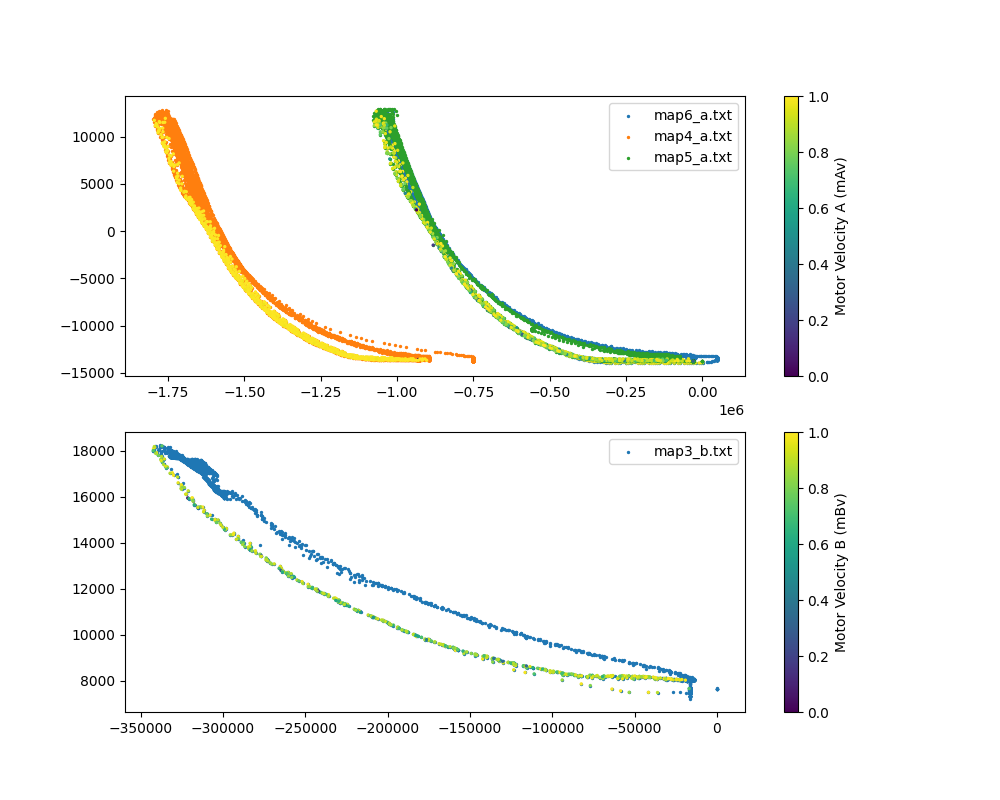

In [191]:
a_dfs = []
b_dfs = []
for file_path in glob.glob(f"*a.txt"):
    df = extract_from_txt(
        file_path, 
        [
            't',
            'pA',
            'pB',
            'mA',
            'mB',
            'eA', 
            'eB', 
            'I'
        ],
        '#'
    )
    df = df[np.abs(df['mA'] - df['mA'].mean()) < 1e6] #remove outliers

    dt = (df['t'][len(df)-1] - df['t'][0])/len(df) / 1000
    fs = 1/dt
    df['mAv'] = np.diff(df['mA'], prepend=0)
    df['mAv_filt'] = butterworth_filter(df['mAv'], 0.3, fs)



    a_dfs.append((file_path, df))

for file_path in glob.glob(f"*b.txt"):
    df = extract_from_txt(
        file_path, 
        [
            't',
            'pA',
            'pB',
            'mA',
            'mB',
            'eA', 
            'eB', 
            'I'
        ],
        '#'
    )
    
    dt = (df['t'][len(df)-1] - df['t'][0])/len(df) / 1000
    fs = 1/dt
    df['mBv'] = np.diff(df['mB'], prepend=0)
    df['mBv_filt'] = butterworth_filter(df['mBv'], 0.3, fs)

    

    b_dfs.append((file_path, df))




fig, axs = plt.subplots(2,1, figsize=(10,8))

for (file_path,df) in a_dfs:
    axs[0].scatter(df['mA'], df['eA'], s=2, label=file_path)

    df = df[df['mAv'] <= -5000]  # Drop rows where mBv is above 4000
    df = df[df['mAv_filt'] <= 0]  # Drop rows where mBv_filt is positive

    axs[0].scatter(df['mA'], df['eA'], s=2, c=df['mAv'])
cbar = fig.colorbar(axs[0].collections[0], ax=axs[0], orientation='vertical')
cbar.set_label('Motor Velocity A (mAv)')



for (file_path,df) in b_dfs:
    axs[1].scatter(df['mB'], df['eB'], s=2, label=file_path)

    df = df[df['mBv'] <= -5000]  # Drop rows where mBv is above 4000
    df = df[df['mBv_filt'] <= 0]  # Drop rows where mBv_filt is positive

    axs[1].scatter(df['mB'], df['eB'], s=2, c=df['mBv'])

cbar = fig.colorbar(axs[1].collections[0], ax=axs[1], orientation='vertical')
cbar.set_label('Motor Velocity B (mBv)')

for ax in axs:
    ax.legend()

Polynomial([ 2.61482635e+04, -8.59619485e-02,  9.30034905e-08, -3.16800579e-14,
       -1.48205751e-21], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

[26148, -0.085962, 9.3003e-08, -3.168e-14, -1.4821e-21]


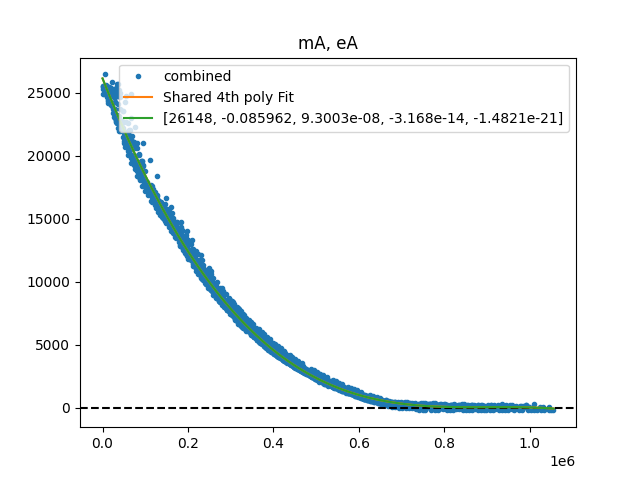

In [192]:
from numpy.polynomial import Polynomial

plt.figure()


all_mAs = np.array([])
all_eAs = np.array([])
for (name,df) in a_dfs:
    # plt.plot(df['t'], df['mA'])
    df = df[df['mAv'] <= -5000]  # Drop rows where mBv is above 4000
    df = df[df['mAv_filt'] <= 0]  # Drop rows where mBv_filt is positive

    df['mA'] = df['mA'] - min(df['mA'])

    # plt.plot(df['mA'], df['eA'], '.', label=name)

    all_mAs = np.concatenate([all_mAs, df['mA'].values])
    all_eAs = np.concatenate([all_eAs, df['eA'].values])

lowest_eAs = np.sort(all_eAs)[:200]
all_eAs = all_eAs - np.mean(lowest_eAs)

plt.plot(all_mAs, all_eAs, '.', label="combined")
plt.axhline(color='k', linestyle='--')

p = Polynomial.fit(all_mAs, all_eAs, 4).convert()
display(p)
print(f"[{', '.join(map(lambda x: f'{x:.5g}', p.coef))}]") 

x_vals = np.linspace(all_mAs.min(), all_mAs.max(), 100)
y_vals = p(x_vals)
plt.plot(x_vals, y_vals, label='Shared 4th poly Fit')

#double check
coeffs = [26148, -0.085962, 9.3003e-08, -3.168e-14, -1.4821e-21]
polynomial = Polynomial(coeffs)
plt.plot(x_vals, polynomial(x_vals), label=f"{coeffs}")

plt.title("mA, eA")
plt.legend()

plt.savefig('stringA.pdf')


Polynomial([ 9.88593339e+03, -9.25739291e-02,  4.17920021e-07, -1.19703090e-12,
        1.54611430e-18], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

[9885.9, -0.092574, 4.1792e-07, -1.197e-12, 1.5461e-18]


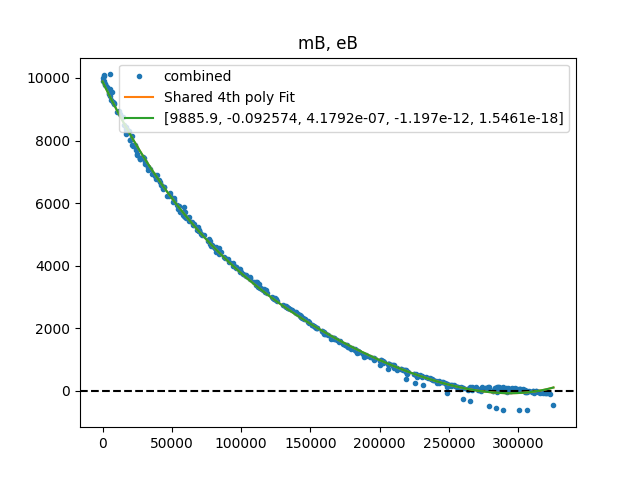

In [193]:
from numpy.polynomial import Polynomial

plt.figure()


all_mBs = np.array([])
all_eBs = np.array([])
for (name, df) in b_dfs:
    df = df[df['mBv'] <= -5000]
    df = df[df['mBv_filt'] <= 0]

    df['mB'] = df['mB'] - min(df['mB'])

    # plt.plot(df['mB'], df['eB'], '.', label=name)

    all_mBs = np.concatenate([all_mBs, df['mB'].values])
    all_eBs = np.concatenate([all_eBs, df['eB'].values])

lowest_eBs = np.sort(all_eBs)[:100]
all_eBs = all_eBs - np.mean(lowest_eBs)

plt.plot(all_mBs, all_eBs, '.', label='combined')
plt.axhline(color='k', linestyle='--')

p = Polynomial.fit(all_mBs, all_eBs, 4).convert()
display(p)
print(f"[{', '.join(map(lambda x: f'{x:.5g}', p.coef))}]") 

x_vals = np.linspace(all_mBs.min(), all_mBs.max(), 100)
y_vals = p(x_vals)
plt.plot(x_vals, y_vals, label='Shared 4th poly Fit')

coeffs = [9885.9, -0.092574, 4.1792e-07, -1.197e-12, 1.5461e-18]
polynomial = Polynomial(coeffs)
plt.plot(x_vals, polynomial(x_vals), label=f"{coeffs}")

plt.title("mB, eB")
plt.legend()

plt.savefig('stringB.pdf')
